In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import albumentations
from PIL import Image
from scipy import ndimage
from skimage.transform import resize

from tqdm import tqdm
from typing import Dict
from IPython.display import clear_output

import torch
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from utils.eda_utils import *
from utils.train_utils import train_monitor
from dataloader.dataloader import SegmentationDataset
from dataloader.transformations import *
from models.model_unet import UNet
from models.model_resnet_unet import ResUNet
from models.train import *
from models.evaluate import *

plt.style.use('ggplot')

In [ ]:
DATA_PATH = './semantic_segm_data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'val')

In [ ]:
def set_lucky_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_lucky_seed(13)

# UNet

In [ ]:
# CONFIGS 

dl_cfg = {
    'erosion_kernel': (2, 2),
    'dilation_kernel': (3, 3),
    'img_size': (256, 256),
    'p_flip': 0.5,
    'bs': 32,
    'labels_range': {'human': [(190, 0, 0), (255, 60, 100)],
                     'car': [(0, 0, 60), (20, 70, 160)]},
}

unet_cfg = {
    'encoder_channels': (3, 64, 128, 256, 512),
    'decoder_channels': (512, 256, 128, 64),
    'n_classes': 3,
    'retain_dim': True,
    'out_size': (256, 256)
}

train_cfg = {
    'lr': 1e-3,
    'n_iter': 2000,
    'n_iter_val': 50,
    'class_weights': [0.1, 0.6, 0.3],
    'plot_mode': True,
    'save_best_val': True,
    'checkpoint_path': './weights'
}

In [ ]:
transforms_train = Compose(
    [Normalize(),
     Augmentations(dl_cfg['p_flip']),
     TargetMask(dl_cfg['labels_range'],
                dl_cfg['erosion_kernel'],
                dl_cfg['dilation_kernel']),
     MoveAxis()]
)

transforms_val = Compose(
    [Normalize(),
     TargetMask(dl_cfg['labels_range'],
                dl_cfg['erosion_kernel'],
                dl_cfg['dilation_kernel']),
     MoveAxis()]
)

dataset_train = SegmentationDataset(TRAIN_PATH, transforms_train)
dataset_val = SegmentationDataset(VAL_PATH, transforms_val)

dataloader_train_unet = DataLoader(dataset_train, dl_cfg['bs'], shuffle=True)
dataloader_val_unet = DataLoader(dataset_val, dl_cfg['bs'], shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

unet = UNet(unet_cfg).to(device)

optimizer = optim.Adam(unet.parameters(), lr=train_cfg['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.9, verbose=True)

w = torch.Tensor(train_cfg['class_weights']).type(torch.float32).to(device)
criterion = nn.CrossEntropyLoss(w)

Device: cuda:0
Adjusting learning rate of group 0 to 1.0000e-03.


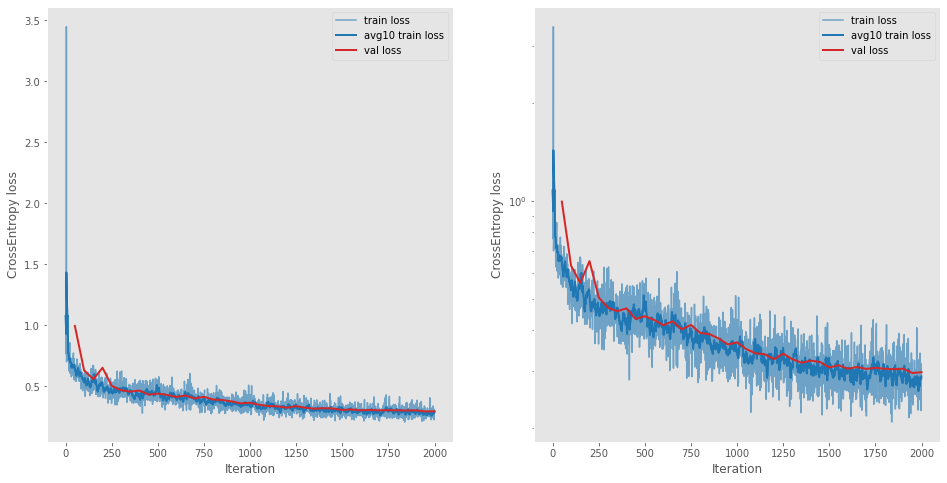



loss: 0.29358, avg loss: 0.37933: 100%|██████████| 2000/2000 [49:40<00:00,  1.49s/it]


In [ ]:
train_model(unet,
            dataloader_train_unet,
            dataloader_val_unet,
            device,
            optimizer,
            criterion,
            scheduler,
            train_cfg)

# ResNet-UNet:

In [ ]:
# CONFIGS 

dl_cfg = {
    'erosion_kernel': (2, 2),
    'dilation_kernel': (3, 3),
    'img_size': (224, 224),
    'p_flip': 0.5,
    'bs': 16,
    'labels_range': {'human': [(190, 0, 0), (255, 60, 100)],
                     'car': [(0, 0, 60), (20, 70, 160)]},
}

resunet_cfg = {
    'decoder_channels': (2048, 1024, 512, 256, 64),
    'n_classes': 3,
    'retain_dim': True,
    'out_size': (224, 224)
}

train_cfg = {
    'lr': 1e-3,
    'n_iter': 2000,
    'n_iter_val': 50,
    'class_weights': [0.1, 0.6, 0.3],
    'plot_mode': True,
    'save_best_val': True,
    'checkpoint_path': './weights'
}

In [ ]:
transforms_train = Compose(
    [Normalize(),
     Augmentations(dl_cfg['p_flip']),
     TargetMask(dl_cfg['labels_range'],
                dl_cfg['erosion_kernel'],
                dl_cfg['dilation_kernel']),
     Resize(dl_cfg['img_size']),
     MoveAxis()]
)

transforms_val = Compose(
    [Normalize(),
     TargetMask(dl_cfg['labels_range'],
                dl_cfg['erosion_kernel'],
                dl_cfg['dilation_kernel']),
     Resize(dl_cfg['img_size']),
     MoveAxis()]
)

dataset_train = SegmentationDataset(TRAIN_PATH, transforms_train)
dataset_val = SegmentationDataset(VAL_PATH, transforms_val)

dataloader_train = DataLoader(dataset_train, dl_cfg['bs'], shuffle=True)
dataloader_val = DataLoader(dataset_val, dl_cfg['bs'], shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

resunet = ResUNet(resunet_cfg).to(device)

optimizer = optim.Adam(resunet.parameters(), lr=train_cfg['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9, verbose=True)

w = torch.Tensor(train_cfg['class_weights']).type(torch.float32).to(device)
criterion = nn.CrossEntropyLoss(w)

Device: cuda:0
Adjusting learning rate of group 0 to 1.0000e-03.


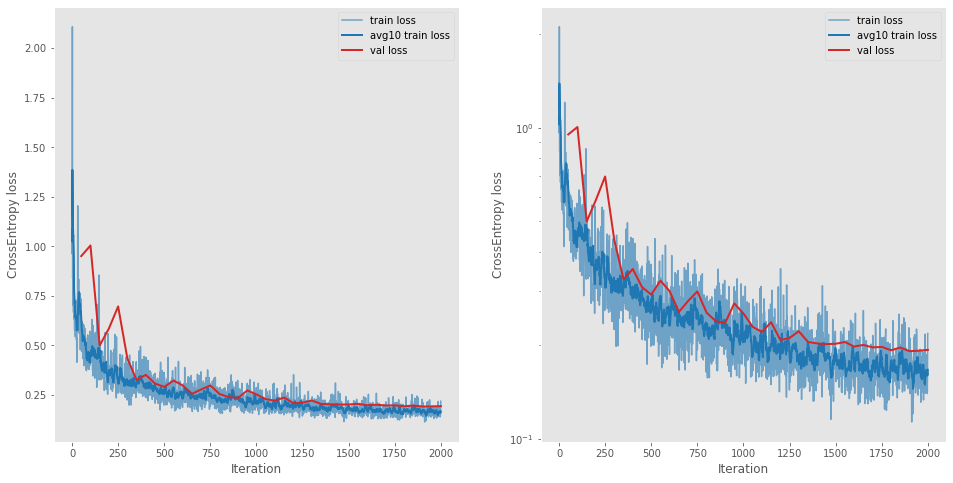





loss: 0.21841, avg loss: 0.24944: 100%|██████████| 2000/2000 [1:14:46<00:00,  2.24s/it]


In [ ]:
train_model(resunet,
            dataloader_train,
            dataloader_val,
            device,
            optimizer,
            criterion,
            scheduler,
            train_cfg)

# Eval
Few visual examples on val set for both models:

In [ ]:
val_it = iter(dataloader_val)
x, y = next(val_it)

pred_mask_unet = predict_mask(unet, x.to(device))
pred_mask_resunet = predict_mask(resunet, x.to(device))

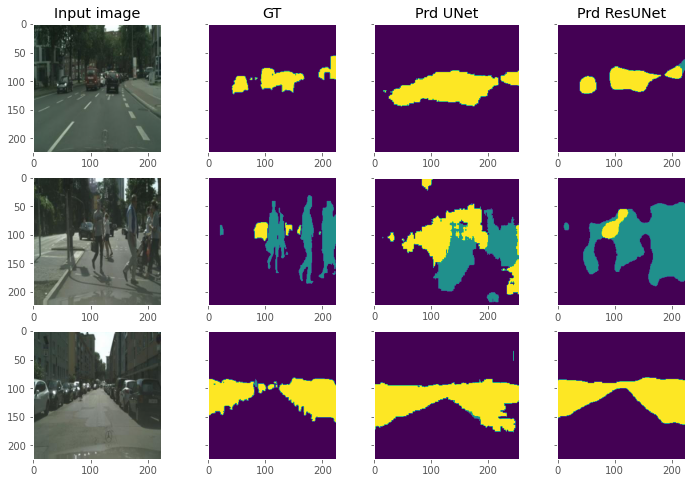

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8), sharey=True)

for i in range(3):
  ax[i][0].imshow(x_to_img(x[i]))
  ax[i][1].imshow(y[i])
  ax[i][2].imshow(pred_mask_unet[i])
  ax[i][3].imshow(pred_mask_resunet[i])
  for j, title in enumerate(['Input image', 'GT', 'Prd UNet', 'Prd ResUNet']):
    ax[0][j].set_title(title)
    ax[i][j].grid(False)

# Metrics
Mean Dice, Jaccard and Recall over labels of val set:

In [ ]:
labels = ['backgnd', 'human', 'car']

Dice:

In [ ]:
dice_u = score_model(unet, dataloader_val_unet, dice, device)
dice_ru = score_model(resunet, dataloader_val, dice, device)

Jaccard:

In [ ]:
jaccard_u = score_model(unet, dataloader_val_unet, jaccard, device)
jaccard_ru = score_model(resunet, dataloader_val, jaccard, device)

Recall:

In [ ]:
recall_u = score_model(unet, dataloader_val_unet, recall, device)
recall_ru = score_model(resunet, dataloader_val, recall, device)

In [ ]:
metrics = [
           ('Dice', dice_u, dice_ru),
           ('Jaccard', jaccard_u, jaccard_ru),
           ('Recall', recall_u, recall_ru)
]

Summary plot:

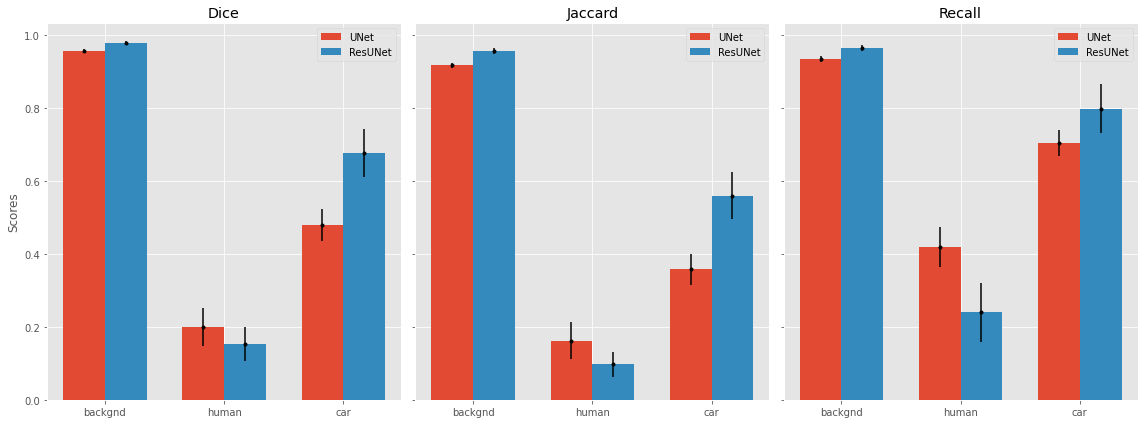

In [ ]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

for i, metric in enumerate(metrics):
  name, mu, mru = metric
  ax[i].bar(x - width/2, mu[0], width, label='UNet')
  ax[i].errorbar(x - width/2, mu[0], yerr=mu[1], fmt='.k')
  ax[i].bar(x + width/2, mru[0], width, label='ResUNet')
  ax[i].errorbar(x + width/2, mru[0], yerr=mru[1], fmt='.k')

  ax[i].set_title(name)
  ax[i].set_xticks(x)
  ax[i].set_xticklabels(labels)
  ax[i].legend()
  
ax[0].set_ylabel('Scores')
fig.tight_layout()

In [ ]:
mean_unet = np.mean([dice_u[0], jaccard_u[0], recall_u[0]])
mean_resunet = np.mean([dice_ru[0], jaccard_ru[0], recall_ru[0]])

print(f'UNet average score: {mean_unet:.3f}')
print(f'ResUNet average score: {mean_resunet:.3f}')

UNet average score: 0.569
ResUNet average score: 0.602


**Summary:**
* UNet is better in 'human' class segmentation.
* ResUNet is better in 'car' class segmentation.
* ResUNet is better in average.